# Workflow

In [1]:
import numpy as np
import healpy as hp
from pygdsm import GlobalSkyModel
import matplotlib.pyplot as plt

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj
from flicker_model import sim_noise

from TOD_simulator import Tsys_model, overall_operator
from full_Gibbs_sampler import full_Gibbs_sampler_single_TOD

## Scan

Coordinates:
- MeerKAT Telescope Location:
	-	Latitude: -30.7130° S
	-	Longitude: 21.4430° E

- Antenna pointing directions:
	-	Azimuth
	-	Elevation

- Diffuse sky coordinates:
	-	RA 
	-	DEC

- healpy expects (theta, phi) in spherical coordinates:
	-	theta = pi/2 - DEC
	-	phi = RA

In [2]:
# Antenna position: Latitude: -30.7130° S; Longitude: 21.4430° E.

# ---- Define telescope location ----
telescope_lat = -30.7130  # MeerKAT latitude in degrees
telescope_lon = 21.4430   # MeerKAT longitude in degrees
telescope_height = 1054    # MeerKAT altitude in meters

location = EarthLocation(lat=telescope_lat * u.deg, lon=telescope_lon * u.deg, height=telescope_height * u.m)

# ---- Define observation parameters ----

# Antenna pointings: Azimuth list and Elevation, in degrees
# azimuths = np.linspace(-60, -40, 111)
azimuths = np.linspace(-65, -35, 168)
azimuths = np.concatenate((azimuths, azimuths[1:-1][::-1]))

# Generate 13 repeats of the azimuths
azimuths = np.tile(azimuths, 25)

elevation = 41.7    # Elevation in degrees

# Total length of TOD
ntime = len(azimuths)
print("Total length of TOD: ", ntime)
dtime = 2.0

t_list = np.arange(ntime) * dtime 

# ---- Define start and end times in SAST ----
start_time_sast = "2024-02-23 19:54:07.397"
#end_time_sast = "2024-02-23 22:12:04.632"

# ---- Convert to UTC (SAST = UTC+2) ----
start_time = Time(start_time_sast) - TimeDelta(2 * u.hour)
#end_time = Time(end_time_sast) - TimeDelta(2 * u.hour)

# ---- Generate time list using numpy.arange ----
dt = 2  # Time step in seconds
time_list = start_time + TimeDelta(t_list, format='sec')

# ---- Create AltAz coordinate frame ----
altaz_frame = AltAz(obstime=time_list, location=location)

# ---- Convert Az/El to Equatorial (RA, Dec) ----
horizon_coords = SkyCoord(az=azimuths*u.deg, alt=elevation*u.deg, frame=altaz_frame)
equatorial_coords = horizon_coords.transform_to("icrs")

# Convert the equatorial coordinates to pixel indices
# Note: healpy expects (theta, phi) in spherical coordinates
theta_c = np.pi/2 - equatorial_coords.dec.radian  # Convert Dec to theta
phi_c = equatorial_coords.ra.radian               # RA is already phi

Total length of TOD:  8350


Text(0, 0.5, 'Elevation (deg)')

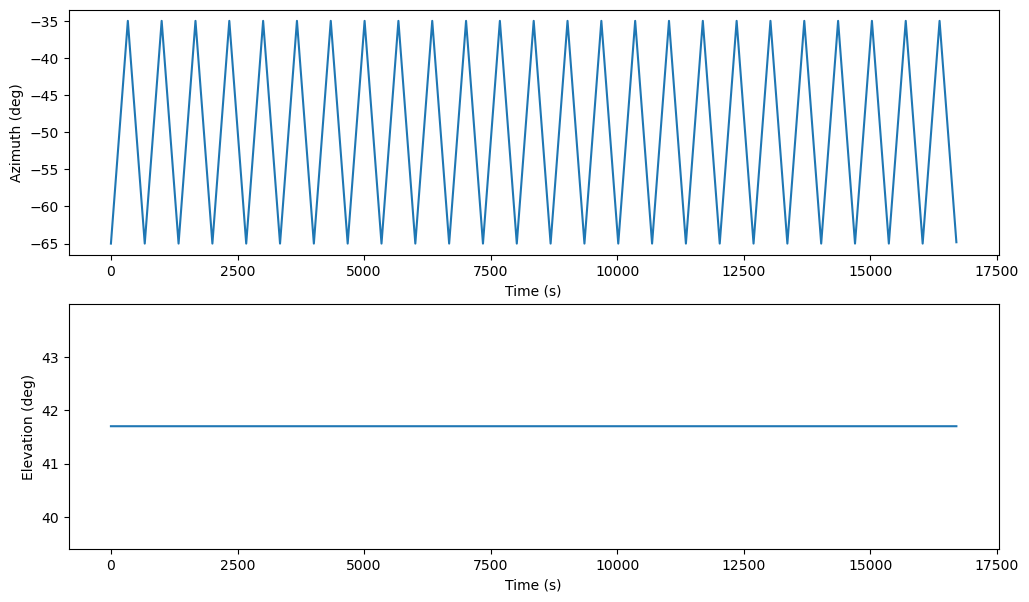

In [3]:
plt.figure(figsize=(12, 7))
# Generate the equatorial coordinates of the pointings:
ra_list = []
dec_list = []

plt.subplot(211)
plt.plot(t_list, azimuths)
plt.xlabel('Time (s)')
plt.ylabel('Azimuth (deg)')

plt.subplot(212)
plt.plot(t_list, elevation*np.ones_like(azimuths))
plt.xlabel('Time (s)')
plt.ylabel('Elevation (deg)')


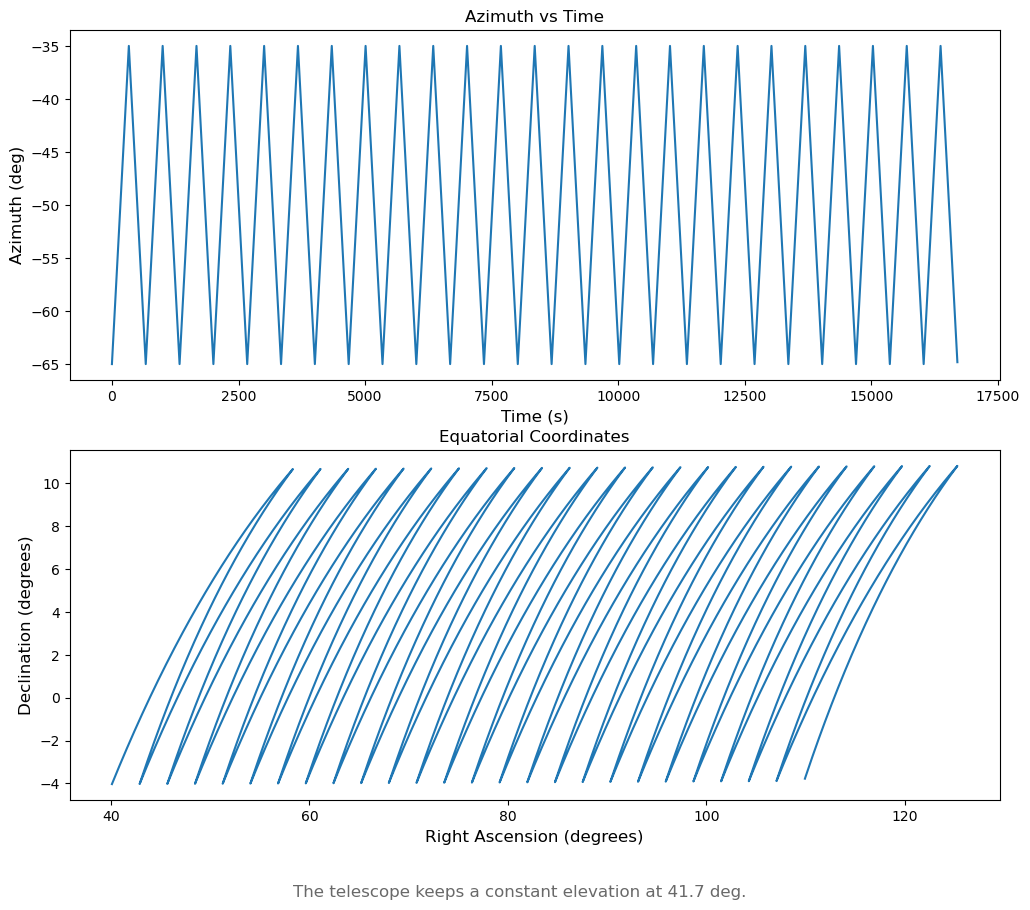

In [23]:
plt.figure(figsize=(12, 10))
# Generate the equatorial coordinates of the pointings:
ra_list = []
dec_list = []

ftsize=12
plt.subplot(211)
plt.plot(t_list, azimuths)
plt.xlabel('Time (s)', fontsize=ftsize)
plt.ylabel('Azimuth (deg)', fontsize=ftsize)
plt.title("Azimuth vs Time", fontsize=ftsize)

plt.subplot(212)
plt.plot(equatorial_coords.ra, equatorial_coords.dec)
plt.xlabel("Right Ascension (degrees)", fontsize=ftsize)
plt.ylabel("Declination (degrees)", fontsize=ftsize)
plt.title("Equatorial Coordinates", fontsize=ftsize)

# Add footnote
plt.figtext(0.5, 0.01, "The telescope keeps a constant elevation at 41.7 deg.",  color='dimgray',
            ha='center', va='bottom', fontsize=ftsize)

plt.savefig('pointings.pdf')


### Beam setup

 Gaussian Beam (FWHM = 1.1 degrees)

$
\text{FWHM} = 2 \sigma \sqrt{2 \ln(2)}
$

In [5]:
# Define beam parameters
FWHM = 1.1  # Full Width at Half Maximum in degrees
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma (degrees)
sigma_rad = np.radians(sigma)  # Convert to radians

def pixel_angular_size(nside):
    """Compute the angular size (in degrees and arcminutes) of a HEALPix pixel."""
    npix = hp.nside2npix(nside)  # Total number of pixels
    omega_pix = 4 * np.pi / npix  # Pixel area in steradians
    theta_pix_deg = np.sqrt(omega_pix) * (180 / np.pi)  # Approximate pixel width in degrees
    theta_pix_arcmin = theta_pix_deg * 60  # Convert to arcminutes
    return theta_pix_deg, theta_pix_arcmin

# Example usage
nside = 64 # Change NSIDE as needed
theta_deg, theta_arcmin = pixel_angular_size(nside)
print(f"NSIDE = {nside}")
print(f"Pixel angular size: {theta_deg:.6f} degrees ({theta_arcmin:.2f} arcminutes)")

NSIDE = 64
Pixel angular size: 0.916130 degrees (54.97 arcminutes)


Number of covered pixels: 1369


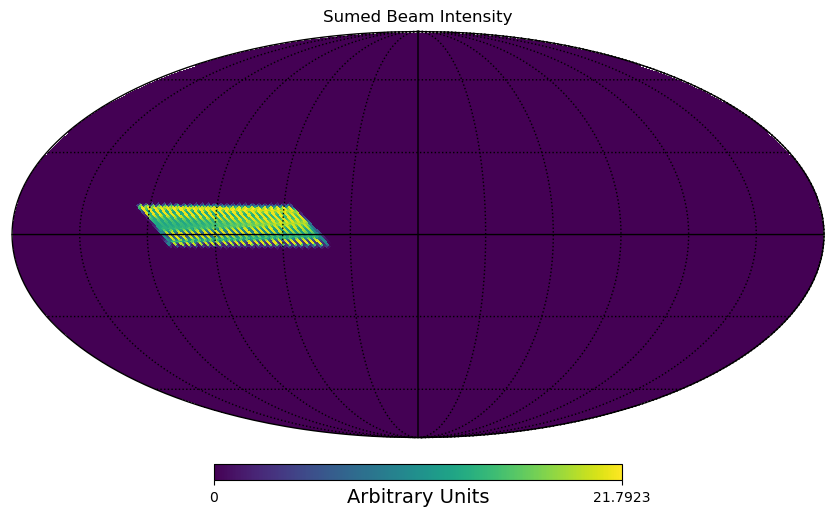

In [ ]:
# Define HEALPix resolution
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)  

# Get HEALPix pixel coordinates (theta, phi)
theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))

# Generate a initial boolean map with all pixels zero
bool_map = np.zeros(NPIX, dtype=bool)
sum_map = np.zeros(NPIX, dtype=float)
# ---- Set the threshold ----
threshold = 1e-1  # Example: Get all pixels where the value is > 0.

for ti in range(ntime):
    # Compute angular separation between each pixel and the beam center
    cos_sep = np.cos(theta) * np.cos(theta_c[ti]) + np.sin(theta) * np.sin(theta_c[ti]) * np.cos(phi - phi_c[ti])
    cos_sep = np.clip(cos_sep, -1, 1)  # Ensure within valid range
    angular_sep = np.arccos(cos_sep)  # Separation in radians
    # Compute Gaussian beam response centered at (RA_center, Dec_center)
    beam_map = np.exp(-0.5 * (angular_sep / sigma_rad) ** 2)
    # Normalize the beam (optional, ensures peak = 1)
    beam_map /= np.max(beam_map)
    sum_map += beam_map
    # Get the "or" map of the bool_map and beam_map
    bool_map = np.logical_or(bool_map, beam_map > threshold)

# Count the number of "1" pixels in bool_map
num_pixels = np.sum(bool_map)
print(f"Number of covered pixels: {num_pixels}")

# Get the pixel indices of the "1" pixels:
pixel_indices = np.where(bool_map)[0]

# Save HEALPix map to file
#hp.write_map("gaussian_beam_pointing.fits", beam_map, overwrite=True)

# Plot the beam in Mollweide projection
hp.mollview(sum_map, title=f"Total Beam Intensity", unit="Arbitrary Units")
hp.graticule()

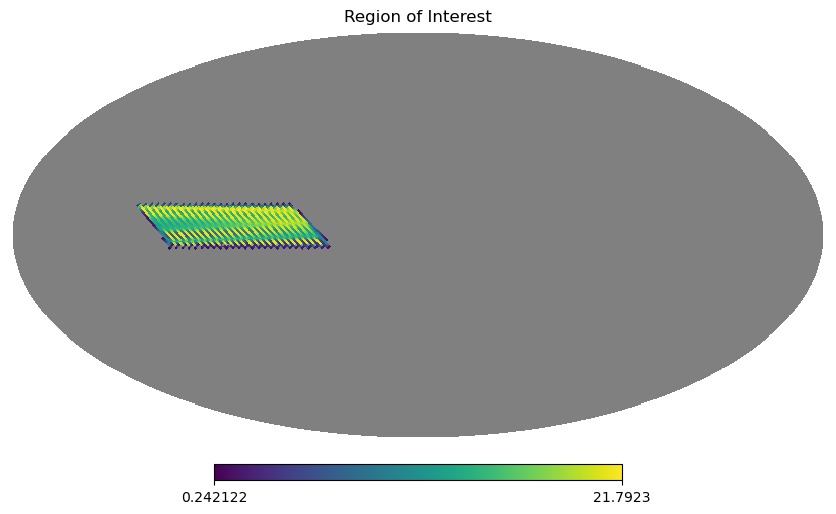

In [26]:
def view_patch_map(map, pixel_indices):
    # Create a new map with just the patch (other pixels set to UNSEEN)
    patch_only_map = np.full(len(map), hp.UNSEEN)
    patch_only_map[pixel_indices] = map[pixel_indices]
    return patch_only_map


# Create a new map with just the patch (other pixels set to UNSEEN)
patch_only_map = view_patch_map(sum_map, pixel_indices)


# Plot just the patch

hp.mollview(patch_only_map, title="Region of Interest")
# Save the figure
plt.savefig("total_beam_intensity.pdf")

plt.show()

In [8]:
# Get pixels of skymap where corresponding mask value (bool_map) is true 
beam_proj = np.zeros((ntime, num_pixels))

for ti in range(ntime):
    # Compute angular separation between each pixel and the beam center
    cos_sep = np.cos(theta) * np.cos(theta_c[ti]) + np.sin(theta) * np.sin(theta_c[ti]) * np.cos(phi - phi_c[ti])
    cos_sep = np.clip(cos_sep, -1, 1)  # Ensure within valid range
    angular_sep = np.arccos(cos_sep)  # Separation in radians
    # Compute Gaussian beam response centered at (RA_center, Dec_center)
    beam_map = np.exp(-0.5 * (angular_sep / sigma_rad) ** 2)
    # Normalize the beam (optional, ensures peak = 1)
    beam_map /= np.max(beam_map)
    beam_proj[ti] = beam_map[pixel_indices]

norm=np.sum(beam_proj, axis=1)
beam_proj/=norm[:,None]


### Sky temperature simulation

In [9]:
from pygdsm import GlobalSkyModel
gsm = GlobalSkyModel()
skymap = gsm.generate(500)
skymap = hp.ud_grade(skymap, nside_out=NSIDE)
true_Tsky = skymap[pixel_indices]

### Noise diode setup

In [10]:
# generate a vector of length ntime, every 10 elements there is a 1, the rest is 0
def generate_vector(ntime):
    vector = np.zeros(ntime)
    for i in range(0, ntime, 10):
        vector[i] = 1
    return vector

ndiode_proj = generate_vector(ntime)

T_ndiode = 10.0

### Receiver temperature

In [11]:
rec_proj = Leg_poly_proj(4, t_list)[:, 1:]
rec_params=np.array([1, 0.5, 1])
# plt.title("Receiver temperature")
# plt.plot(rec_proj @ rec_params)

### Gain and noise setup 

In [12]:
gain_proj = Leg_poly_proj(4, t_list)
gain_params=np.array([2, 0.5, 1.5, 0.5])*2
mu0 = np.sin(2*np.pi*0.1*t_list)
gains = gain_proj @ gain_params + mu0

f0, fc, alpha = 1e-4, 2e-5, 2.0
sigma_2 = 1/(4e5)

noise = sim_noise(f0, fc, alpha, t_list, n_samples=1, white_n_variance=sigma_2)[0]

TOD_ndiode = T_ndiode*ndiode_proj
TOD_rec = rec_proj @ rec_params
Tsys_sim = Tsys_model([beam_proj, rec_proj, ndiode_proj], [true_Tsky, rec_params, T_ndiode])
TOD_sim = Tsys_sim * (1+noise) * gains 
Tsys_proj = overall_operator([beam_proj, rec_proj])

logn_params = [np.log10(f0), np.log10(fc), alpha]


## Visualization of the simulation of a single TOD and the results of the sampling

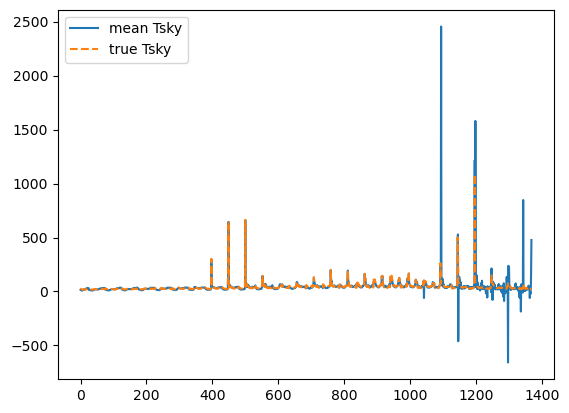

In [13]:
# read off the samples from Tsys_samples.npy
#
Tsys_samples = np.load('single_TOD_Tsys_samples.npy')
Tsky_samples = Tsys_samples[:, :num_pixels]
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)

# plot the mean with error bars
# plt.errorbar(range(len(Tmean)), Tmean, yerr=Tstd, fmt='o', label='mean Tsky')
plt.plot(range(len(Tmean)), Tmean, label='mean Tsky')
plt.plot(range(len(Tmean)), true_Tsky, label='true Tsky', linestyle='--')
#plt.ylim(5, 15)
plt.legend()


In [14]:
# Show the healpix maps

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = true_Tsky
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd


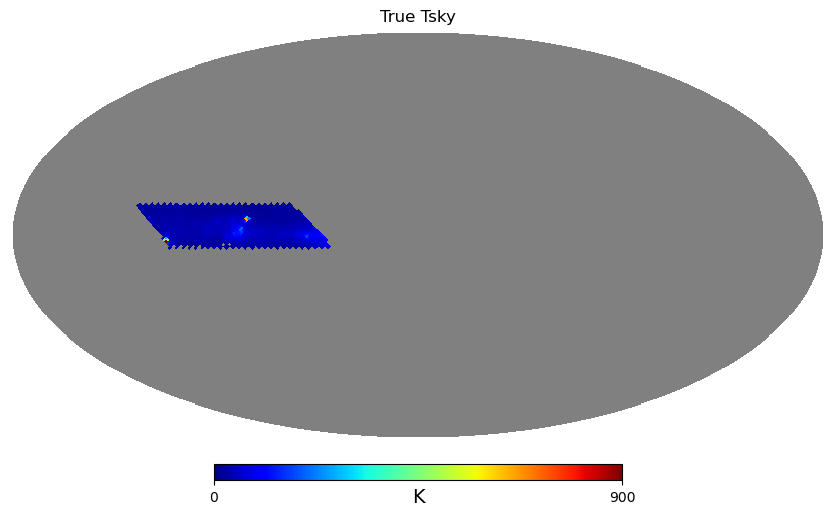

In [25]:
# healpy view the true_map and sample_mean_map using the saved colorbar
patch_true_map = view_patch_map(true_map, pixel_indices)
hp.mollview(patch_true_map, title="True Tsky", unit="K", cmap='jet', min=0, max=900)
plt.savefig("true_map.pdf")

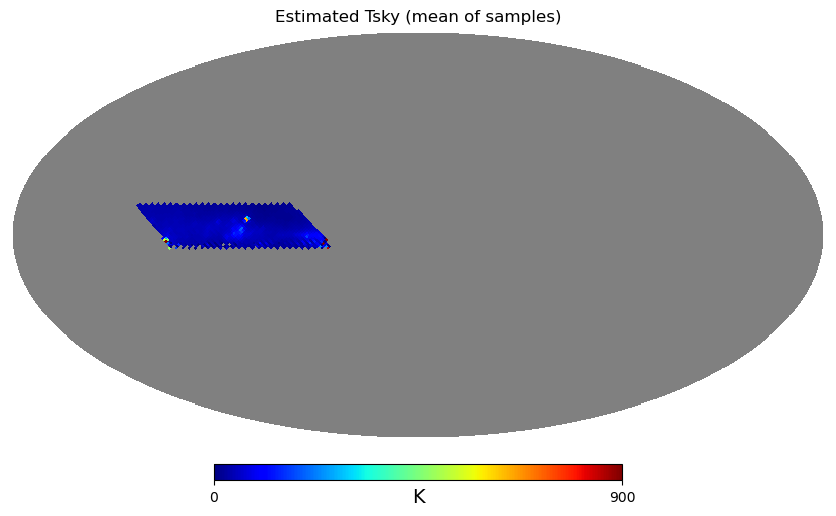

In [28]:
patch_mean_map = view_patch_map(sample_mean_map, pixel_indices)
hp.mollview(patch_mean_map, title="Estimated Tsky (mean of samples)", unit="K", cmap='jet', min=0, max=900)
plt.savefig("est_map.pdf")

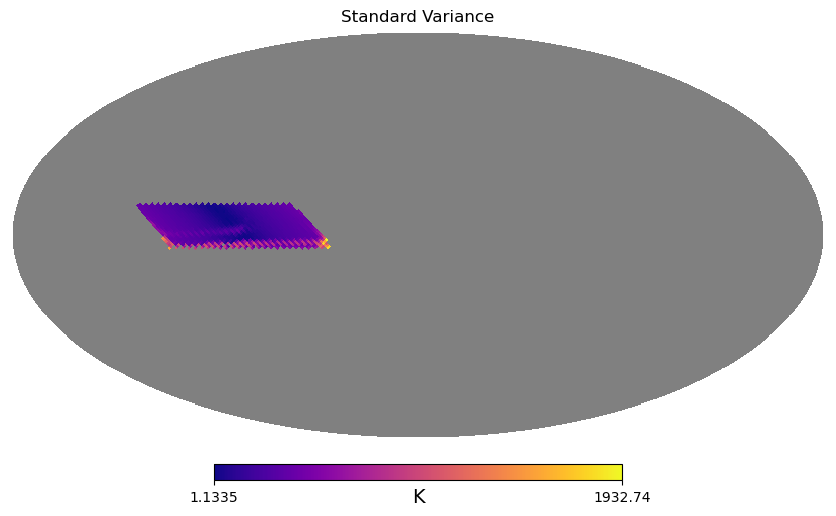

In [29]:
patch_std_map = view_patch_map(sample_std_map, pixel_indices)
hp.mollview(patch_std_map, title='Standard Variance', unit='K', cmap='plasma', norm='log')
plt.savefig('std_map.pdf')

# Test Tsky sampler